# DARE Deluxe Data Challenge
DARE 2023

In this notebook, we will provide a template for the DARE Deluxe Data Challenge. The main steps covered here will be:

- Load the data
- Provide an overview of what is in the data
- Provide an example of a terribly performing baseline model
- Provide functions to quantify model predictive performance


TODO:
- ENSURE THIS IS ALIGNED PROPERLY - AT PRESENT IT IS MOST CORRELATED AT LAG = 1
- GET DEM elevation at each gauge

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


## Imports and settings
Everything we need to get started.

In [77]:
import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# import functions
from functions.preprocessing import (
    load_environode, convert_environode_daily, daily_averaging,
    load_llara_gauges, load_silo_gauges
)

## 1 Load the data
Briefly look at the contents and structure of the data.

In [58]:
date_start = '2021-12-15' #based on initial plotting
date_end = '2023-03-31' #based on initial plotting

## 1.1 Soil Moisture Data

In [59]:
data_dir = os.path.join('.','data','raw_data')
filestub = 'Download'
rm_gauges = ['WE 16-07 B0', 'WW 12-03 93']

sm_comb = load_environode(data_dir,filestub,utc_to_aest=True)
# get rid of the sticky-outy bit
sm_comb.drop(columns=['v1'],inplace=True)
# drop duplicate gauges
sm_comb = sm_comb.loc[~sm_comb['device'].isin(rm_gauges),:]
# remove dates before the start date
sm_comb = sm_comb.loc[sm_comb['Date'] >= pd.to_datetime(date_start).tz_localize('Australia/Sydney'),:]
# sm_comb.head()

daily_sm_data = convert_environode_daily(sm_comb,type='9am-mean')
# Data cleaning as per Willem's code
vcols = [c for c in sm_comb.columns if c.startswith('v')]
for this_v in vcols:
    daily_sm_data.loc[daily_sm_data[this_v]<0,this_v] = np.nan
    daily_sm_data.loc[daily_sm_data[this_v]>125,this_v] = np.nan

# keep v2 - v6
daily_sm_data = daily_sm_data.loc[:,['Date','device','v2','v3','v4','v5','v6']]
daily_sm_data = daily_sm_data.loc[
    (daily_sm_data['Date']>= pd.to_datetime(date_start)) & \
    (daily_sm_data['Date']<= pd.to_datetime(date_end)),
    :]
display(daily_sm_data.head())
display(daily_sm_data.tail())

./data/raw_data/Download2022-04-17_2021-10-19.csv
./data/raw_data/Download2023-04-12_2022-10-14.csv
./data/raw_data/Download2022-10-14_2022-04-17.csv
Summarising daily data per device - 32 gauges
Gauge: WE 12-08 A8 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 16-03 B3 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 12-05 A5 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 16-06 B6 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 12-06 A6 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 16-07 A7 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 16-08 B8 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 12-04 A4 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 12-03 A3 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WW 12-07 97 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 12-02 A2 start: 2021-12-15 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 16-02 B2 star

,Date,device,v2,v3,v4,v5,v6
0,2021-12-15,WE 12-08 A8,6.563617,5.173191,17.173617,28.371915,43.610213
1,2021-12-16,WE 12-08 A8,18.555965,14.037632,22.202632,44.792193,62.681930
2,2021-12-17,WE 12-08 A8,18.163050,13.123121,20.058227,39.678440,57.420355
3,2021-12-18,WE 12-08 A8,17.420923,12.007231,18.062692,34.394231,50.009615
4,2021-12-19,WE 12-08 A8,16.671189,11.056014,16.499650,30.457552,43.601329


,Date,device,v2,v3,v4,v5,v6
15471,2023-03-27,WW 12-03 AE,11.615211,9.953662,9.903944,9.783662,10.545211
15472,2023-03-28,WW 12-03 AE,11.922113,9.949718,9.890000,9.792394,10.560986
15473,2023-03-29,WW 12-03 AE,13.825139,10.910139,9.925417,9.800833,10.562500
15474,2023-03-30,WW 12-03 AE,18.922639,17.061667,15.257639,10.880417,10.555139
15475,2023-03-31,WW 12-03 AE,18.077500,16.767083,16.436944,14.524028,10.807917


In [37]:
# data_dir = os.path.join('.','data','raw_data')
# filestub = 'Rainfall'
# date_start = '2021-12-15' #based on initial plotting

# rain_comb = load_environode(data_dir,filestub,utc_to_aest=True)
# # remove dates before the start date
# rain_comb = rain_comb.loc[rain_comb['Date'] >= pd.to_datetime(date_start).tz_localize('Australia/Sydney'),:]
# # sm_comb.head()

# daily_rain_data = convert_environode_daily(rain_comb,type='9am')
# # Data cleaning 

# # keep v2 - v6
# # daily_sm_data = daily_sm_data.loc[:,['Date','device','v2','v3','v4','v5','v6']]
# daily_rain_data = daily_rain_data.pivot(index='Date',columns='device',values='v17')
# daily_rain_data.plot()

## 1.2 Rainfall Data


In [60]:
# now get from other llara rain gauges
llara_gauges = {
    'mulgate': 'Llara_Mulgate_Creek-19900101-MF6IW2.csv',
    # 'south': 'Llara_South-19900101-bNI22T.csv',
    'wheat': 'Wheat_Research_Narrabri-19900101-VRyvYZ.csv'
}
col_convert = {
    'Time': 'Date',
    ' Rain Since 9am (mm)': 'rain',
    ' Temperature (C)': 'temp',
    ' Rel Humidity (%)': 'relhumidity',
    ' Solar Rad (kWh/m^2)': 'solarrad',
    ' Wind (km/h)': 'windspeed',
    ' Wind Dir': 'winddir',
    ' MSLP (hPa)': 'mlsp',
    ' UV': 'uv'
}

llara_data = load_llara_gauges(data_dir,llara_gauges,col_convert)
# drop if a gauge is missing that varibale entirely
llara_data = llara_data.dropna(axis=1,how='all')

# remove dates before the start date
llara_data = llara_data[date_start:date_end]

display(llara_data.head())
display(llara_data.tail())

Llara_Mulgate_Creek-19900101-MF6IW2.csv
Wheat_Research_Narrabri-19900101-VRyvYZ.csv


,rain_mulgate,temp_mulgate,windspeed_mulgate,winddir_mulgate,relhumidity_mulgate,solarrad_mulgate,rain_wheat,temp_wheat,windspeed_wheat,winddir_wheat,mlsp_wheat,relhumidity_wheat,solarrad_wheat,uv_wheat
Time,,,,,,,,,,,,,,
2021-12-15,0.0,22.877083,9.018750,172.635417,49.364583,2.841563,0.0,22.752632,7.625263,137.557895,1012.421579,51.810526,3.155368,2.410526
2021-12-16,0.0,25.510417,5.725000,163.375000,47.062500,3.304896,0.0,25.438710,5.022581,156.451613,1011.006989,49.064516,3.445591,2.549462
2021-12-17,0.0,24.384375,6.504167,164.239583,60.760417,1.912396,0.0,24.291667,5.560417,137.770833,1012.353125,61.635417,1.951458,1.550000
2021-12-18,0.0,27.860417,12.108333,210.489583,53.708333,2.883854,0.0,28.127083,12.477083,112.604167,1013.450000,53.000000,3.130417,2.423958
2021-12-19,0.0,28.530208,13.817708,159.104167,52.135417,3.191354,0.0,28.824211,13.729474,110.315789,1014.117368,50.831579,3.355368,2.686316


,rain_mulgate,temp_mulgate,windspeed_mulgate,winddir_mulgate,relhumidity_mulgate,solarrad_mulgate,rain_wheat,temp_wheat,windspeed_wheat,winddir_wheat,mlsp_wheat,relhumidity_wheat,solarrad_wheat,uv_wheat
Time,,,,,,,,,,,,,,
2023-03-27,3.2,24.664583,6.966667,122.604167,71.333333,1.564688,0.00,24.438298,8.250000,92.531915,1013.257872,72.723404,1.640106,1.073404
2023-03-28,0.0,24.564583,9.188542,123.375000,74.375000,1.799479,1.68,24.317895,11.463158,137.157895,1013.392000,76.989474,1.750000,1.196842
2023-03-29,33.8,23.764583,10.473958,84.656250,80.406250,0.747188,52.64,23.593814,10.927835,100.247423,1012.011856,82.030928,0.759588,0.517526
2023-03-30,1.2,20.537500,9.015625,225.552083,84.093750,1.456771,3.08,20.792784,10.381443,249.092784,1008.559691,84.608247,1.386701,0.635052
2023-03-31,0.0,16.954167,7.303125,189.302083,65.093750,2.144896,0.00,16.563158,8.181053,144.115789,1011.799684,71.084211,2.295368,1.003158


## 1.3 SILO Data


In [65]:
# We will also load the silo data for the same period

# now get from other llara rain gauges
silo_gauges = {
    'narrabri': '53026.txt',
    'turrawan': '55058.txt',
}
col_convert = {
    'Date': 'Date',
    'Rain': 'rain',
    'T.Max': 'tempmax',
    'T.Min': 'tempmin',
    'Evap': 'evap',
}

silo_data = load_silo_gauges(data_dir,silo_gauges,col_convert)

# evap needs to be moved forward a day to overlap the same period
# thanks to SILOs interpretation
for _ in silo_data.columns:
    if 'evap' in _:
        silo_data[_] = silo_data[_].shift(1)

# remove dates before the start date
silo_data = silo_data[date_start:date_end]

display(silo_data.head())
display(silo_data.tail())

,tempmax_narrabri,tempmin_narrabri,rain_narrabri,evap_narrabri,tempmax_turrawan,tempmin_turrawan,rain_turrawan,evap_turrawan
Date,,,,,,,,
2021-12-15,33.9,15.6,0.0,7.5,33.4,14.2,0.0,7.2
2021-12-16,31.8,17.7,0.0,7.6,31.2,16.9,0.0,7.3
2021-12-17,35.2,18.2,0.0,5.7,34.6,17.6,0.0,5.5
2021-12-18,35.0,22.1,0.0,7.1,34.5,20.9,0.0,6.7
2021-12-19,35.0,21.5,0.0,7.7,34.3,20.3,0.0,7.3


,tempmax_narrabri,tempmin_narrabri,rain_narrabri,evap_narrabri,tempmax_turrawan,tempmin_turrawan,rain_turrawan,evap_turrawan
Date,,,,,,,,
2023-03-27,32.2,19.6,0.0,3.9,31.3,18.7,3.9,3.8
2023-03-28,32.1,20.9,0.2,3.3,30.3,20.1,0.0,3.2
2023-03-29,28.6,19.0,34.0,3.7,27.9,18.7,22.2,3.6
2023-03-30,24.9,12.8,1.2,3.5,24.5,13.0,4.3,3.4
2023-03-31,23.1,9.4,0.1,3.8,22.6,9.1,0.0,3.7


## 1.4 Meta Data


,site,loc,treatment,treatment rep,longitude,latitude,geometry
0,WW,WW_12_01,Treatment,T1,149.842307,-30.262072,POINT (149.84231 -30.26207)
1,WW,WW_12_01,Treatment,T1,149.842307,-30.262072,POINT (149.84231 -30.26207)
2,WW,WW_16_01,Treatment,T2,149.844457,-30.263997,POINT (149.84446 -30.26400)
3,WW,WW_16_01,Treatment,T2,149.844457,-30.263997,POINT (149.84446 -30.26400)
4,WW,WW_12_02,Treatment,T3,149.846010,-30.260622,POINT (149.84601 -30.26062)


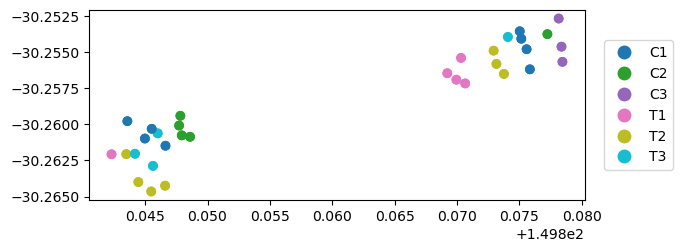

In [79]:
sm_meta = pd.read_csv(os.path.join(data_dir,'sm_gauge_metadata.csv'))
# convert loc_meta into a geopandas dataframe
sm_meta = gpd.GeoDataFrame(
    sm_meta, geometry=gpd.points_from_xy(sm_meta.longitude, sm_meta.latitude)
)
sm_meta.loc[:,'loc'] = sm_meta.loc[:,'loc'].str.strip()
# and transform to EPSG 23855
sm_meta = sm_meta.set_crs('EPSG:4326')
# sm_meta = sm_meta.to_crs('EPSG:28355')

cmap = sns.color_palette("Set2", as_cmap=True)

ax = sm_meta.plot(column='treatment rep',legend=True)#color=loc_meta['treatment'].astype('category').cat.codes.map(cmap))
ax.get_legend()._set_loc(6)
ax.get_legend().set_bbox_to_anchor((1.025, 0.5))

sm_meta.head()

## 2 Dataset description


In [62]:
# lets look at some properties of the data
print('#'*80) 
print('Soil Moisture Summary') 
print('Number of gauges: {}'.format(daily_sm_data['device'].unique().shape[0]))
print('Number of depths: {}'.format(daily_sm_data.columns.shape[0]-2))
print('Number of observations: {}'.format(daily_sm_data.shape[0]))
for this_depth in ['v2','v3','v4','v5','v6']:
    print('Number of NaNs: {} for {}'.format(daily_sm_data[this_depth].isna().sum(),this_depth))

display(daily_sm_data.describe())

print('#'*80) 
print('Llara Rain Summary') 
print('Number of gauges: {}'.format(llara_data.columns.shape[0]))
print('Number of observations: {}'.format(llara_data.shape[0]))
for this_gauge in llara_data.columns:
    print('Number of NaNs: {} for {}'.format(llara_data[this_gauge].isna().sum(),this_gauge))

display(llara_data.describe())

print('#'*80) 
print('SILO Summary') 
print('Number of gauges: {}'.format(silo_data.columns.shape[0]))
print('Number of observations: {}'.format(silo_data.shape[0]))
for this_gauge in silo_data.columns:
    print('Number of NaNs: {} for {}'.format(silo_data[this_gauge].isna().sum(),this_gauge))

display(silo_data.describe())

################################################################################
Soil Moisture Summary
Number of gauges: 32
Number of depths: 5
Number of observations: 15104
Number of NaNs: 296 for v2
Number of NaNs: 296 for v3
Number of NaNs: 296 for v4
Number of NaNs: 298 for v5
Number of NaNs: 297 for v6


,v2,v3,v4,v5,v6
count,14808.000000,14808.000000,14808.000000,14806.000000,14807.000000
mean,25.831231,27.686792,28.844630,29.790871,32.250083
std,19.006453,20.956322,22.184717,23.700740,23.747567
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.262909,11.797704,11.321500,10.779278,12.952324
50%,20.276555,20.508490,21.601382,21.991389,24.773147
75%,35.630868,40.849356,41.611354,42.841493,48.280704
max,98.017917,92.503472,98.742083,100.082500,110.184167


################################################################################
Llara Rain Summary
Number of gauges: 14
Number of observations: 472
Number of NaNs: 0 for rain_mulgate
Number of NaNs: 0 for temp_mulgate
Number of NaNs: 0 for windspeed_mulgate
Number of NaNs: 0 for winddir_mulgate
Number of NaNs: 0 for relhumidity_mulgate
Number of NaNs: 0 for solarrad_mulgate
Number of NaNs: 0 for rain_wheat
Number of NaNs: 0 for temp_wheat
Number of NaNs: 0 for windspeed_wheat
Number of NaNs: 0 for winddir_wheat
Number of NaNs: 0 for mlsp_wheat
Number of NaNs: 0 for relhumidity_wheat
Number of NaNs: 0 for solarrad_wheat
Number of NaNs: 0 for uv_wheat


,rain_mulgate,temp_mulgate,windspeed_mulgate,winddir_mulgate,relhumidity_mulgate,solarrad_mulgate,rain_wheat,temp_wheat,windspeed_wheat,winddir_wheat,mlsp_wheat,relhumidity_wheat,solarrad_wheat,uv_wheat
count,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000
mean,1.855085,19.320828,8.468712,171.879715,66.753710,2.044404,2.410847,19.338841,8.950666,153.657162,1015.044662,67.527739,2.079267,1.333092
std,6.546260,6.242900,5.013042,33.784284,13.392745,0.815012,7.590667,6.419985,4.372802,43.123421,5.505608,14.122854,0.882465,0.858547
min,0.000000,5.779167,0.051042,34.458333,36.218750,0.228750,0.000000,5.537634,2.058947,27.418367,997.917634,36.063830,0.167340,0.010417
25%,0.000000,14.601302,4.934896,162.875000,55.638021,1.358333,0.000000,14.363093,5.701383,130.567063,1011.344666,55.619515,1.262319,0.477884
50%,0.000000,20.205729,7.878125,178.541667,68.505208,2.125990,0.000000,20.398936,8.136916,147.300717,1014.939918,70.457499,2.173392,1.205789
75%,0.200000,24.404167,11.013021,186.828125,76.255208,2.751172,0.000000,24.464478,11.527926,175.699188,1019.206892,78.336814,2.890109,2.170221
max,81.600000,31.477083,25.855208,291.593750,95.000000,3.365714,64.960000,31.834375,25.624742,320.719101,1027.036316,94.739583,3.657582,3.036559


################################################################################
SILO Summary
Number of gauges: 8
Number of observations: 472
Number of NaNs: 0 for tempmax_narrabri
Number of NaNs: 0 for tempmin_narrabri
Number of NaNs: 0 for rain_narrabri
Number of NaNs: 0 for evap_narrabri
Number of NaNs: 0 for tempmax_turrawan
Number of NaNs: 0 for tempmin_turrawan
Number of NaNs: 0 for rain_turrawan
Number of NaNs: 0 for evap_turrawan


,tempmax_narrabri,tempmin_narrabri,rain_narrabri,evap_narrabri,tempmax_turrawan,tempmin_turrawan,rain_turrawan,evap_turrawan
count,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000
mean,27.214619,12.888136,2.276271,4.620339,26.965254,12.306992,1.731568,4.506356
std,6.717997,6.146702,7.633688,2.237276,6.604275,6.156961,5.119485,2.199402
min,12.500000,-1.900000,0.000000,0.600000,12.200000,-2.700000,0.000000,0.500000
25%,21.400000,8.775000,0.000000,2.600000,21.275000,8.200000,0.000000,2.575000
50%,27.700000,14.200000,0.000000,4.400000,27.300000,13.500000,0.000000,4.250000
75%,33.000000,17.725000,0.000000,6.500000,32.725000,17.200000,0.000000,6.400000
max,40.300000,24.600000,67.800000,9.700000,40.000000,23.400000,35.000000,9.500000


# 3 Combine the data

In [67]:
# combine all of our daily dataframes into one
daily_data = pd.concat([silo_data,llara_data],axis=1,sort=True)
daily_data.sort_index(inplace=True)
daily_data.sort_index(axis=1,inplace=True)
# constrain to the soil moisture data period
daily_data = daily_data.loc[daily_sm_data['Date'].min().strftime('%Y-%m-%d'):daily_sm_data['Date'].max().strftime('%Y-%m-%d'),:]
# drop any all nan columns
daily_data.dropna(axis=1,how='all',inplace=True)
daily_data

,evap_narrabri,evap_turrawan,mlsp_wheat,rain_mulgate,rain_narrabri,rain_turrawan,rain_wheat,relhumidity_mulgate,relhumidity_wheat,solarrad_mulgate,...,temp_wheat,tempmax_narrabri,tempmax_turrawan,tempmin_narrabri,tempmin_turrawan,uv_wheat,winddir_mulgate,winddir_wheat,windspeed_mulgate,windspeed_wheat
2021-12-15,7.5,7.2,1012.421579,0.0,0.0,0.0,0.00,49.364583,51.810526,2.841563,...,22.752632,33.9,33.4,15.6,14.2,2.410526,172.635417,137.557895,9.018750,7.625263
2021-12-16,7.6,7.3,1011.006989,0.0,0.0,0.0,0.00,47.062500,49.064516,3.304896,...,25.438710,31.8,31.2,17.7,16.9,2.549462,163.375000,156.451613,5.725000,5.022581
2021-12-17,5.7,5.5,1012.353125,0.0,0.0,0.0,0.00,60.760417,61.635417,1.912396,...,24.291667,35.2,34.6,18.2,17.6,1.550000,164.239583,137.770833,6.504167,5.560417
2021-12-18,7.1,6.7,1013.450000,0.0,0.0,0.0,0.00,53.708333,53.000000,2.883854,...,28.127083,35.0,34.5,22.1,20.9,2.423958,210.489583,112.604167,12.108333,12.477083
2021-12-19,7.7,7.3,1014.117368,0.0,0.0,0.0,0.00,52.135417,50.831579,3.191354,...,28.824211,35.0,34.3,21.5,20.3,2.686316,159.104167,110.315789,13.817708,13.729474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,3.9,3.8,1013.257872,3.2,0.0,3.9,0.00,71.333333,72.723404,1.564688,...,24.438298,32.2,31.3,19.6,18.7,1.073404,122.604167,92.531915,6.966667,8.250000
2023-03-28,3.3,3.2,1013.392000,0.0,0.2,0.0,1.68,74.375000,76.989474,1.799479,...,24.317895,32.1,30.3,20.9,20.1,1.196842,123.375000,137.157895,9.188542,11.463158
2023-03-29,3.7,3.6,1012.011856,33.8,34.0,22.2,52.64,80.406250,82.030928,0.747188,...,23.593814,28.6,27.9,19.0,18.7,0.517526,84.656250,100.247423,10.473958,10.927835
2023-03-30,3.5,3.4,1008.559691,1.2,1.2,4.3,3.08,84.093750,84.608247,1.456771,...,20.792784,24.9,24.5,12.8,13.0,0.635052,225.552083,249.092784,9.015625,10.381443


# 4 Train/Test Split

Training data

In [ ]:
train_data = daily_data.loc[:'2019-12-31',:]
print('Training data is around {:.2f}% of the total data'.format(train_data.shape[0]/hourly_data.shape[0]*100))
print('Training - number of hourly observations: {} of {}'.format(train_data.dropna().shape[0],train_data.shape[0]))

Test data

In [ ]:
# now split the test data - conveniently about 20%
test_data = hourly_data.loc['2017-08-03 21:00':,:]
print('Test data is around {:.2f}% of the total data'.format(test_data.shape[0]/hourly_data.shape[0]*100))
print('Test - number of hourly observations: {} of {}'.format(test_data.dropna().shape[0],test_data.shape[0]))

In [ ]:
# Lets now save the training and test data as hourly mean
train_data.to_csv('data/daily_train_data.csv')
test_data.to_csv('data/daily_test_data.csv')

# 5 Plot for checking

In [71]:
# plot the data
from ipywidgets import interact, fixed
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns

#imports from plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# function to plot R2 of soil moisture to rainfall and various lag in rainfall
def plot_r2_lag(rain_data,sm_data,rain_name,sm_name,lag):
    # get the data
    rain = rain_data[rain_name]
    sm = sm_data.loc[sm_data['device']==sm_name].set_index('Date')[['v2']]
    # combine the two dataframes
    df = pd.concat([rain,sm],axis=1)
    # now plot with plotly express top plot should be a barplot of rainfall in the y and index in the x,
    # bottom plot should be the timeseries of soil moisture
    fig = make_subplots(rows=2,cols=1,shared_xaxes=True)
    fig.add_trace(go.Bar(x=df.index,y=df[rain_name],name=rain_name),row=1,col=1)
    fig.add_trace(go.Scatter(x=df.index,y=df['v2'],name=sm_name),row=2,col=1)
    fig.update_layout(height=400,width=600)
    fig.show()

    sm = sm.diff()
    
    #.diff()
    # shift the rain data by the lag
    rain_shift = rain.shift(lag)
    lag_plot = pd.concat([rain_shift,sm],axis=1)
    lag_plot.dropna(inplace=True)
    lag_plot = lag_plot.loc[lag_plot[rain_name]>0,:]
    # plot
    fig, ax = plt.subplots(figsize=(3,3))
    sns.scatterplot(data=lag_plot,x=rain_name,y='v2',ax=ax)
    ax.set_title('R2 = {:.2f}'.format(lag_plot.corr().iloc[0,1]**2))
    ax.set_xlabel(f'{rain_name} shifted by {lag} days')
    ax.set_ylabel(f'{sm_name} - v2')
    # plt.show()
    return


interact(
    plot_r2_lag,
    rain_data=fixed(daily_data),
    sm_data=fixed(daily_sm_data),
    rain_name=widgets.Dropdown(options=[_ for _ in daily_data.columns if 'rain' in _]),
    sm_name=widgets.Dropdown(options=list(daily_sm_data.device.unique())),
    lag = widgets.IntSlider(min=-5,max=5,step=1,value=0)
)

None

interactive(children=(Dropdown(description='rain_name', options=('rain_mulgate', 'rain_narrabri', 'rain_turraw…